In [1]:
import numpy as np
from typing import Tuple,Callable
from scipy.integrate import quadrature, odeint
import matplotlib.pyplot as plt

%matplotlib inline

# Linear ODE with direction fields

In [2]:
def func(x):
    return x**3 + 2 * x**2 - 3**x

In [3]:
def mc_int(func: Callable, domain: Tuple, n_samples: int):
    samples = np.random.uniform(low=domain[0], high=domain[1], size=(n_samples,))
    volume = abs(domain[1] - domain[0])
    return np.mean(func(samples)) * volume

In [4]:
def mi_ode(func, y0, x, n_samples):
    
    vals = [y0]
    for lo, hi in zip(x[:-1], x[1:]):
        vals.append(vals[-1] + mc_int(func, (lo, hi), n_samples))
    return np.asarray(vals)
    

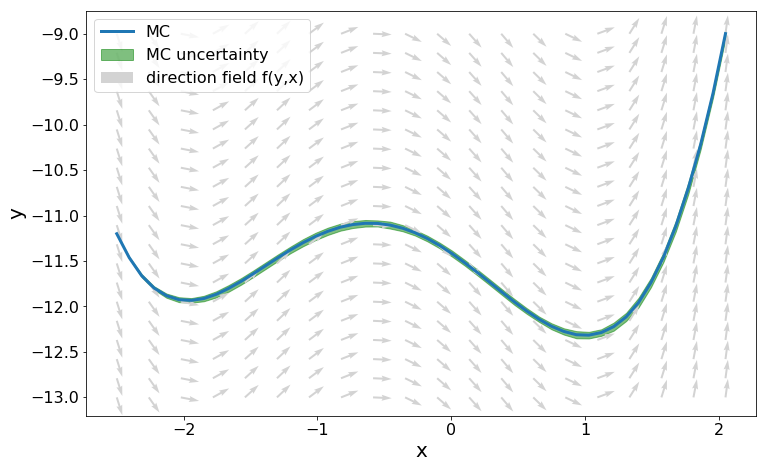

In [5]:
xs = np.linspace(-2.5, 2.05, 50)
y0 = -11.2
ys = []
for _ in range(5):
    y = mi_ode(func, y0, xs , 5)
    ys.append(y)
y_mean = np.mean(ys, axis=0)
y_std = np.std(ys, axis=0)

def F(x):
    return x**4 / 4 + 2*x**3/3 - 3*x**2/2


width = 12
height = width / 1.61
fig = plt.figure(figsize=(width, height))

plt.plot(xs, y_mean, linewidth=3, label='MC')
plt.fill_between(xs, y_mean - 3 * y_std, y_mean + 3 * y_std, alpha=.5, color='g', label='MC uncertainty')

xx, yy = np.meshgrid(np.linspace(min(xs), max(xs), 20), np.linspace(-13, -9, 20))

U = 1
V = func(xx)
N = np.sqrt(U**2 + V ** 2)
U2, V2 = U/N, V/N

plt.quiver(xx, yy, U2, V2, color='lightgray', label='direction field f(y,x)')
plt.xlabel(r'x', fontsize=20)
plt.ylabel(r'y', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.legend(loc='upper left', fontsize=16)

fig.savefig('solution_direction_field.png', bbox=True, pad_inches=0.2, dpi=300)

# Monte Carlo Integration

In [6]:
def func(x):
    return np.sinc(x)**2

x = np.arange(-3.51, 3.51, 0.01)
y = func(x)

mus = []
for _ in range(20):
    xr = np.random.uniform(low=min(x), high=max(x), size=500)
    yr = func(xr)
    mu = np.mean(yr)
    sigma = np.std(yr)

    mus.append(mu)
    
exact = quadrature(func, min(x), max(x))[0]
mu = (max(x) - min(x)) * np.mean(mus)
sigma = np.std(mus)

print(exact, mu, sigma)

0.9710166229665382 0.9733821114734965 0.012334660106768423


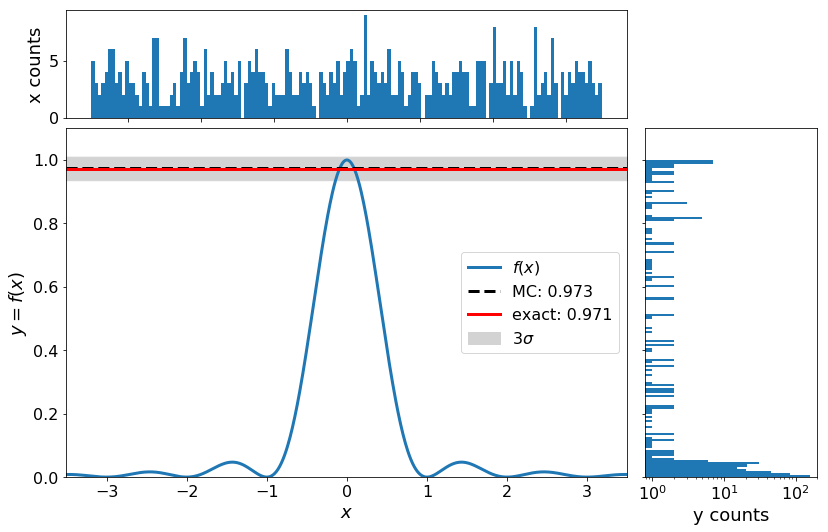

In [7]:
from matplotlib.ticker import NullFormatter
nullfmt = NullFormatter()         # no labels

# definitions for the axes
left, width = 0.1, .65
bottom, height = 0.1, 0.65
bottom_h = left_h = left + width + 0.02

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom_h, width, 0.2]
rect_histy = [left_h, bottom, 0.2, height]

# start with a rectangular Figure
bb_width = 12
bb_height = bb_width / 1.61
plt.figure(1, figsize=(bb_width, bb_height))

axScatter = plt.axes(rect_scatter)
axHistx = plt.axes(rect_histx)
axHisty = plt.axes(rect_histy)

# no labels
axHistx.xaxis.set_major_formatter(nullfmt)
axHisty.yaxis.set_major_formatter(nullfmt)

# the scatter plot:
axScatter.plot(x, y, linewidth=3, label=r'$f(x)$')
axScatter.plot([min(x), max(x)], [mu, mu], 'k--', linewidth=3, label=f'MC: {mu:.3f}')
axScatter.fill_between(x,
                       len(x) * [mu - 3 * sigma],
                       len(x) * [mu + 3 * sigma],
                       color='lightgray', alpha=1, label=r'$3\sigma$')
axScatter.plot([min(x), max(x)], [exact, exact], 'r', linewidth=3, label=f'exact: {exact:.3f}')

# now determine nice limits by hand:
xymax = np.max([np.max(np.fabs(x)), np.max(np.fabs(y))])

axScatter.set_xlim((min(x), max(x)))
axScatter.set_ylim((0, 1.1))

axHistx.hist(xr, bins=150)
axHisty.hist(yr, bins=150, orientation='horizontal', log=True)

axHisty.set_ylim(axScatter.get_ylim())
axScatter.legend(loc='best', fontsize=16)


axScatter.tick_params(axis='both', which='major', labelsize=16)
axScatter.tick_params(axis='both', which='minor', labelsize=12)

axHistx.tick_params(axis='both', which='major', labelsize=16)
axHistx.tick_params(axis='both', which='minor', labelsize=12)

axHisty.tick_params(axis='both', which='major', labelsize=16)
axHisty.tick_params(axis='both', which='minor', labelsize=12)

axHisty.set_xlabel('y counts', fontsize=18)

axHistx.set_ylabel('x counts', fontsize=18)

axScatter.set_xlabel(r'$x$', fontsize=18)
axScatter.set_ylabel(r'$y = f(x)$', fontsize=18)

plt.tight_layout

plt.savefig('mc_integration.png', bbox=True, pad_inches=0.2, dpi=300)

# Nonlinear ODE with MC integration

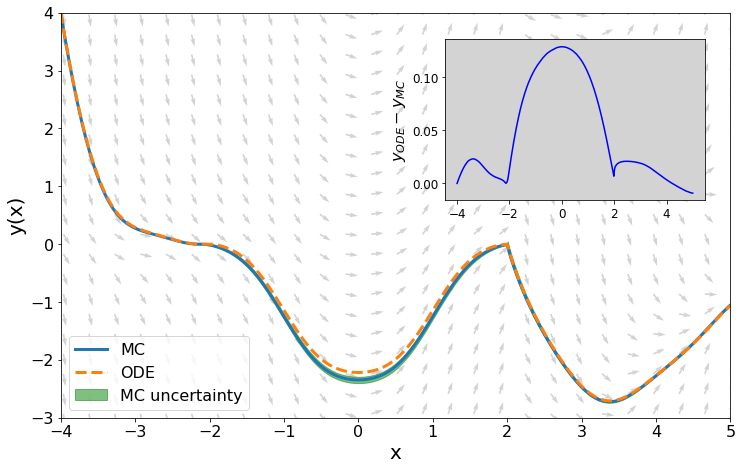

In [8]:
def func(y, x):
    return  x * np.sqrt(np.abs(y)) + np.sin(x * np.pi/2)**3 - 5 * (x > 2)


def mc_int(func: Callable, domain: Tuple, n_samples: int):
    samples = np.random.uniform(low=domain[0], high=domain[1], size=(n_samples,))
    volume = abs(domain[1] - domain[0])
    return np.mean(func(samples)) * volume


def mc_ode_solve(func, y0, t, n_samples=2):
    sols = [y0]
    for lo, hi in zip(t[:-1], t[1:]) :
        part_func = lambda v: func(x=v, y=sols[-1])
        assert lo < hi
        sols.append(sols[-1] + mc_int(part_func, (lo, hi), n_samples=n_samples))
    return np.asarray(sols)


base2 = np.linspace(-4, 5, 500)
y0 = 4.
ys_mc = []
for _ in range(20):
    ys_mc.append(mc_ode_solve(func, y0, base2))


width = 12
height = width / 1.61
fig = plt.figure(figsize=(width, height))

base = np.linspace(-5, 5, 30)
xx, yy = np.meshgrid(base, base)
U = 1
V = func(yy, xx)
N = np.sqrt(U**2 + V ** 2)
U2, V2 = U/N, V/N

plt.quiver(xx, yy, U2, V2, color='lightgray')

y_mc_mean = np.mean(ys_mc, axis=0)
y_mc_std = np.std(ys_mc, axis=0)
y_ode = odeint(func, y0, base2)
plt.plot(base2, y_mc_mean, linewidth=3, label='MC')
plt.fill_between(base2, y_mc_mean - 3 * y_mc_std, y_mc_mean + 3 * y_mc_std, color='g', alpha=0.5, label='MC uncertainty')
plt.plot(base2, y_ode, '--', linewidth=3, label='ODE')
plt.xlabel(r'x', fontsize=20)
plt.ylabel(r'y(x)', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.tick_params(axis='both', which='minor', labelsize=12)

plt.legend(loc='lower left', fontsize=16)
plt.xlim([-4, 5])
plt.ylim([-3, 4])

a = plt.axes([.57, .53, .3, .3], facecolor='lightgray')
plt.plot(base2, y_ode.squeeze() - y_mc_mean, 'b')
plt.ylabel(r'$y_{ODE} - y_{MC}$', fontsize=16);
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=8)


fig.savefig('nl_solution_direction_field.png', bbox=True, pad_inches=0.2, dpi=300)
